# delaunay_simulation

> Simulate tension evolution and real space using Delaunay/Voronoi construction

Goal is to illustrate the simulation workflow. We provide code to create triangulation initial conditions, and some analysis code, in particular how to render movies.

In [ ]:
#| default_exp delaunay

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
import CE_simulation.mesh as msh
import CE_simulation.tension as tns

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import trim_mean
from scipy.linalg import orthogonal_procrustes
from scipy import spatial

from tqdm.notebook import tqdm

from copy import deepcopy

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial
from jax.config import config

config.update("jax_enable_x64", True) 

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Literal
from nptyping import NDArray, Int, Float, Bool, Shape

from fastcore.foundation import patch

In [ ]:
from importlib import reload

# Delaunay simulation


Before we begin to code the optimization routines for the real space shape, here we simulate a mesh using the Delaunay/Voronoi duality. This means that we compute the real-space vertex coordinates using the Voronoi construction, and use the Delaunay criterion to determine edge flips.

### Creating initial conditions

Code to create some initial conditons - patches of triangular lattices.

In [ ]:
#| export

def rot_mat(theta: float) -> NDArray[Shape["2,2"],Float]:
    """Get rotation matrix from angle in radians."""
    return np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

def shear_mat(s: float) -> NDArray[Shape["2,2"],Float]:
    """Get shear matrix diag(s, 1/s)"""
    return np.array([[s, 0],[0, 1/s]])

def scale_mat(s: float) -> NDArray[Shape["2,2"],Float]:
    """Get shear matrix s*Id"""
    return np.diag([s,s])

In [ ]:
#| export

def get_triangular_lattice_convex(nx: int, ny: int) -> NDArray[Shape["2,*"],Float]:
    """Get (points from a) convex patch of triangular lattice of size nx*ny. nx,ny odd."""
    assert ny%2 and nx%2

    max_ny = 2*(nx-1)+1
    ny = min(ny, max_ny)
    
    y = np.arange(0, ny)*np.sqrt(3)/2
    x = np.arange(nx).astype(float)
    X, Y = np.meshgrid(x, y)

    X -= X.mean()+1/2; Y -=Y.mean()

    X = (X.T+(np.arange(ny)%2)/2).T
    pts = np.stack([X, Y]).reshape((2,nx*ny))
    
    theta = np.pi/3
    epsilon = 1e-4
    thr = np.floor(ny/4)
    halfplanes = [np.array([np.sin(theta), np.cos(theta)]),
                  np.array([np.sin(-theta), np.cos(-theta)])]
    vals = halfplanes[0].dot(pts)
    in_0_row = vals[np.abs(pts[1]) < epsilon]    
    is_convex = (vals > in_0_row.min()-epsilon) & (vals < in_0_row.max()+epsilon)
    
    vals = halfplanes[1].dot(pts)
    in_0_row = vals[np.abs(pts[1]) < epsilon]    
    is_convex &= (vals > in_0_row.min()-epsilon) & (vals < in_0_row.max()+epsilon)
    
    pts = pts[:, is_convex]
    pts = (pts.T-pts.mean(axis=1)).T
    return pts

def get_tri_hemesh(nx=7, ny=11, noise: float=0) -> msh.HalfEdgeMesh:
    """Create a half edge mesh of a convex patch of triangular lattice + noise."""
    pts = get_triangular_lattice_convex(nx, ny)
    tri = spatial.Delaunay(pts.T)
    mesh = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(tri.points, tri.simplices))
    mesh.transform_vertices(lambda x: x+np.random.normal(scale=noise, size=(2,)))
    return mesh

(-3.3, 3.3, -4.763139720814412, 4.763139720814412)

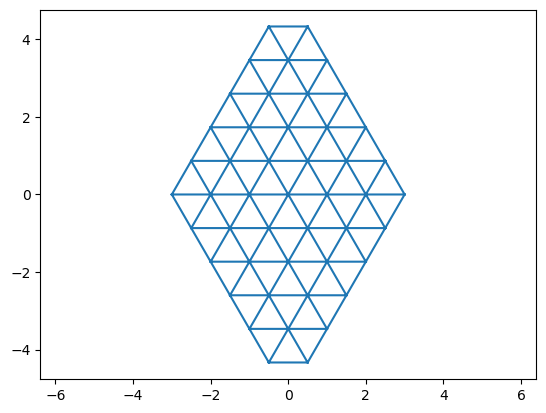

In [ ]:
mesh = get_tri_hemesh()

mesh.triplot()
plt.axis('equal')

In [ ]:
#| export

def get_triangular_lattice(nx: int, ny: int) -> Tuple[NDArray[Shape["2,*"],Float], NDArray[Shape["*"],Bool]]:
    """
    Get points for rectangular patch of triangular lattice with nx, ny points.
    
    Also return a mask which delinates bdry vertices."""

    y = np.arange(0, ny)*np.sqrt(3)/2
    x = np.arange(nx).astype(float)
    X, Y = np.meshgrid(x, y)
    X -= X.mean()+1/2; Y -=Y.mean()
    X = (X.T+(np.arange(ny)%2)/2).T
    pts = np.stack([X, Y]).reshape((2,nx*ny))
    is_bdry = np.zeros_like(X)
    is_bdry[:1] = is_bdry[-1:] = 1
    is_bdry[:,:1] = is_bdry[:,-1:] = 1
    is_bdry = is_bdry.reshape(nx*ny)
    
    return pts, is_bdry

def create_rect_mesh(nx: int, ny: int, noise: float=0, defects=(0,0),
                     straight_bdry=False) -> msh.HalfEdgeMesh:
    """
    Create a half-edge mesh rectangular patch of triangular lattice. 
    
    Edges have length 1 by default. Optionally, add noise to vertex positions and create point defects
    at random positions.
    
    Parameters
    ----------
    
    nx, ny: int
        x- and y- dimensions of lattice patch
    noise: float
        Standard deviation of Gaussian noise to be added to vertex positions
    defects: tuple (int, int)
        Number of missing/duplicate defects
    straight_bdry: bool
        Keep triangles at boundary, which are not equilateral.
        
    Returns
    -------
    mesh: msh.HalfEdgeMesh
    """
    pts, is_bdry = get_triangular_lattice(nx, ny)
    pts[:,~is_bdry.astype(bool)] += np.random.normal(scale=noise, size=(2, (~is_bdry.astype(bool)).sum()))
    if defects[0] > 0:
        ix = np.random.choice(np.where(1-is_bdry)[0], size=defects[0], replace=False)
        pts = np.delete(pts, ix, axis=1)
    if defects[1] > 0:
        ix = np.random.choice(np.where(1-is_bdry)[0], size=defects[1], replace=False)
        split = np.random.choice((0,1), len(ix))
        additional_pts =  pts[:, ix] + .3*np.stack([1-split, split]) 
        pts[:, ix] -= .3*np.stack([1-split, split]) 
        pts = np.hstack([pts, additional_pts])
    
    tri = spatial.Delaunay(pts.T)
    # remove the left, right edge
    if straight_bdry:
        simplices = tri.simplices
    else:
        max_x, min_x = (pts[0].max(), pts[0].min())
        simplices = np.stack([x for x in tri.simplices
                          if (np.isclose(pts[0,x], min_x).sum()<2) and (np.isclose(pts[0,x], max_x).sum()<2)])
    mesh = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(tri.points, simplices))
    
    return mesh

(-5.475, 4.975, -4.286825748732971, 4.28682574873297)

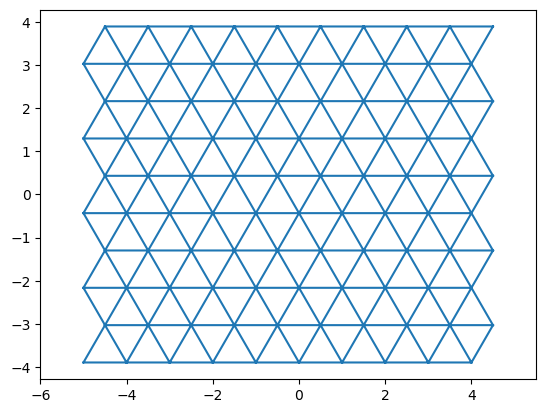

In [ ]:
mesh = create_rect_mesh(10, 10)

mesh.triplot()
plt.axis('equal')

In [ ]:
#| export

def create_rect_mesh_angle(nx: int, ny: int, angle=0, noise=0, max_l=1.2) -> msh.HalfEdgeMesh:
    """
    Create a half-edge mesh rectangular patch of tri lattice, with given angle between y- and lattice axis.

    This differs from create_rect_mesh by allowing to specify the angle 0°-60° between the lattice axis
    and the y-axis. Note that the resulting boundaries are typically not clean.
    
    Edges have length 1 by default. Optionally, add noise to vertex positions.
    
    Parameters
    ----------
    
    nx, ny: int
        x- and y- dimensions of lattice patch
    noise: float
        Standard deviation of Gaussian noise to be added to vertex positions
    max_l: float
        Remove faces with an edge of length > max_l. Non-equilateral triangles can occur at mesh boundary
        
    Returns
    -------
    mesh: msh.HalfEdgeMesh
    """
    pts, _ = get_triangular_lattice(2*max([nx, ny]), 2*max([nx, ny]))
    pts = (pts.T - pts.mean(axis=1)).T
    pts = rot_mat(angle) @ pts

    pts_ref, _ = get_triangular_lattice(nx, ny)
    pts_ref = (pts_ref.T - pts_ref.mean(axis=1)).T
    x_max, y_max = pts_ref.max(axis=1)
    x_min, y_min = pts_ref.min(axis=1)
    x_max += .1; y_max += .1; x_min -= .1; y_min -= .1;

    pts_masked = pts[:, (x_min<=pts[0])&(pts[0]<=x_max)&(y_min<=pts[1])&(pts[1]<=y_max)]
    
    tri = spatial.Delaunay(pts_masked.T)
    # remove simplices with very long edges, which can occur at boundary
    max_lengths = [np.linalg.norm(pts_masked[:,x]-pts_masked[:,np.roll(x, 1)], axis=0).max()
                   for x in tri.simplices]
    simplices = [s for s, l in zip(tri.simplices, max_lengths) if l < max_l]
    mesh = msh.HalfEdgeMesh(msh.ListOfVerticesAndFaces(tri.points, simplices))

    mesh.transform_vertices(lambda v: v+np.random.normal(scale=noise))
    
    return mesh


(-5.320400709816075, 5.24047259619111, -9.136362717812037, 9.15608505209263)

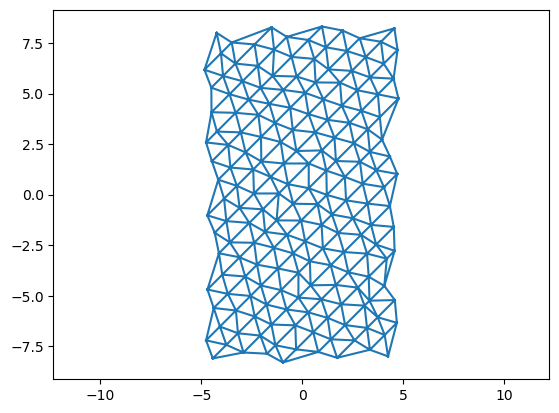

In [ ]:
mesh = create_rect_mesh_angle(10, 20, 15 * np.pi/180, noise=.1, max_l=2)

mesh.triplot()
plt.axis('equal')

### Code for simulation analysis

In [ ]:
#| export

def get_inertia(pts: NDArray[Shape["*,2"],Float], q=0) -> NDArray[Shape["2,2"],Float]:
    """Get inertia tensor of point cloud. q in [0, 1) removes points with outlier x/y coordinates"""
    pts -= trim_mean(pts,q, axis=0)
    x, y = pts.T
    Ixx = trim_mean(x**2, q)
    Ixy = trim_mean(x*y, q)
    Iyy = trim_mean(y**2, q)
    return np.array([[Ixx, Ixy], [Ixy,Iyy]])

#### Creating Dual Shape Factor histograms

In [ ]:
#| export

@patch
def get_vertex_angles(self: msh.HalfEdgeMesh, method: Literal["real", "dual"]="real",
                      exclude: [None, List[int]]=None) -> Dict[int, NDArray[Shape["3"],Float]]:
    """Get dictionary of vertex angles."""
    exclude = [exclude] if exclude is None else exclude
    if method == "dual":
        lengths = {fc._fid: np.array([np.linalg.norm(x.vertices[1].coords-x.vertices[0].coords)
                                      for x in fc.hes])
                   for fc in self.faces.values() if (not (fc._fid in exclude))}
        angles = {key: tns.sides_angles(val) for key, val in lengths.items()}
    if method == "real":
        angles = []
        for fc in self.faces.values():
            if (not (fc._fid in exclude)) and (not fc.is_bdry()):
                vecs = np.stack([he.twin.face.dual_coords-fc.dual_coords for he in fc.hes])
                angle = [np.pi-tns.vectors_angle(x, y) for x,y in zip(vecs, np.roll(vecs, 1, axis=0))]
                angles[fc._fid] = np.array(angle)
    
    return angles

In [ ]:
#| export

def scatter_hist(x, y, bins, fig=None, ticks_off=True, vmin=None, vmax=None):
    """
    Create a square 2d histogram with marginals at top & right sides. Returns main mpl axis.
    
    Parameters
    ----------
    x, y: np.array of shape (n_sample,)
        Sample points
    bins: tuple (np.array, np.array) 
        Histogram bins
    ticks_off: bool
        turn off ticks on the auxilliary marginal axes
    vmin, vmax: float
        Limits of color map
    
    Returns
    -------
    ax: matplotlib axis
    
    """
    
    fig = plt.figure(figsize=(4,4)) if fig is None else fig
    # create the required axes
    gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                          left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx, ax_histy = (fig.add_subplot(gs[0, 0], sharex=ax), fig.add_subplot(gs[1, 1], sharey=ax))

    # no labels on marginal axes
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    if ticks_off:
        ax_histx.set_yticks([],[])
        ax_histy.set_xticks([],[])

    # the scatter plot:
    ax.hist2d(x, y, bins=bins, density=True, cmap="magma", vmin=vmin, vmax=vmax)

    ax_histx.hist(x, bins=bins[0], alpha=.5, density=True)
    ax_histy.hist(y, bins=bins[1], orientation='horizontal', alpha=.5, density=True)
    
    return ax
    
def eqspace(x0: float, x1: float, dx: float) -> NDArray[Shape["*"], Float]:
    """Return equally spaced range between x0, x1, with approx. spacing dx. Cf. np.linspace."""
    return np.linspace(x0, x1, np.round(abs(x1-x0)/dx).astype(int))

In [ ]:
mesh = create_rect_mesh_angle(50, 100, 15 * np.pi/180, noise=.2, max_l=2) # 15
vertex_angles = mesh.get_vertex_angles(method='dual')
dsfs = tns.angles_shape(np.array(list(vertex_angles.values())).T)

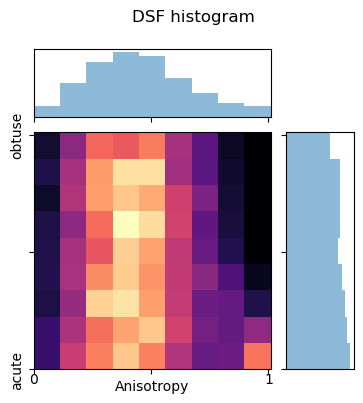

In [ ]:
fig = plt.figure(figsize=(4,4))
fig.suptitle('DSF histogram', y=1.)

bins = [eqspace(0, 1+.01, .1), eqspace(0, 1+.01, .1)]
ax = scatter_hist(dsfs[1], dsfs[0]/np.pi, bins, fig=fig)

ax.set_ylabel("", labelpad=-5)
ax.set_xlabel("Anisotropy", labelpad=-5)
ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
#ax.set_aspect('equal', adjustable='box')
plt.show()

### Rescale two triangulations to best match one another

Allow rotation, translation, scaling. Fix scaling by taking area. Use case: "Stabilize" triangulations during simulation.

In [ ]:
#| export

def get_conformal_transform(mesh1: msh.HalfEdgeMesh, mesh2: msh.HalfEdgeMesh) -> callable:
    """
    Get rotation+scaling+translation to match mesh2's triangulation to mesh1. Preserves overall area.
    """
    bdry1 = np.stack([he.vertices[0].coords for he in mesh1.get_bdry_hes()])
    bdry2 = np.stack([he.vertices[0].coords for he in mesh2.get_bdry_hes()])
    rescale = np.sqrt(msh.polygon_area(bdry1)/msh.polygon_area(bdry2))

    pts1 = np.stack([v.coords for v in mesh1.vertices.values()])
    pts2 = np.stack([v.coords for v in mesh2.vertices.values()])
    mean1, mean2 = (pts1.mean(axis=0), pts2.mean(axis=0))

    rotation = orthogonal_procrustes(rescale*(pts2-mean2), pts1-mean1)[0]

    return lambda x: rotation.T@(rescale*(x-mean2))+mean1


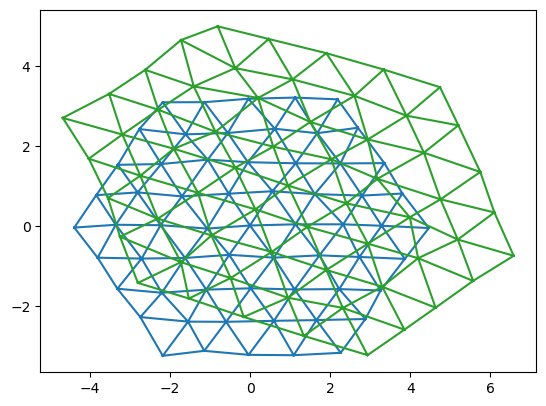

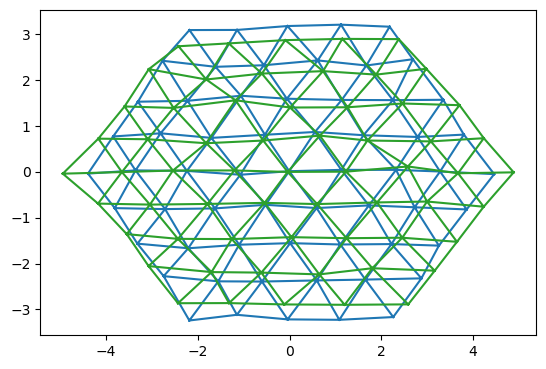

In [ ]:
mesh1 = get_tri_hemesh(noise=0, ny=9, nx=9) # (7,7)
mesh1.transform_vertices(lambda x: shear_mat(1.1)@x+np.random.normal(size=2, scale=0.05)) #0.075
mesh2 = deepcopy(mesh1)
mesh2.transform_vertices(lambda x: 1.2*rot_mat(.3)@shear_mat(1.1)@x+np.random.normal(loc=1, size=2, scale=0.05))

mesh1.triplot()
mesh2.triplot()
plt.gca().set_aspect("equal", adjustable="box");
plt.show()

mesh2.transform_vertices(get_conformal_transform(mesh1, mesh2))

mesh1.triplot()
mesh2.triplot()
plt.gca().set_aspect("equal", adjustable="box");
plt.show()

In [ ]:
[msh.polygon_area(np.stack([he.vertices[0].coords for he in x.get_bdry_hes()])) for x in [mesh1, mesh2]]

[41.26044647052878, 41.2604464705288]

### Plotting uses the Voronoi positions

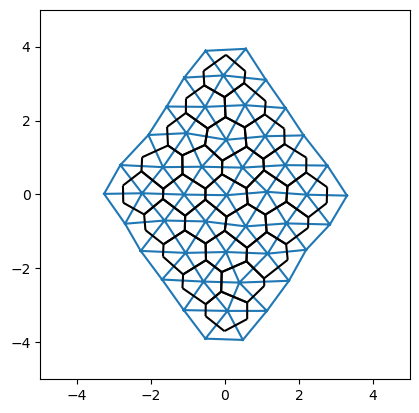

In [ ]:
mesh = get_tri_hemesh(noise=.05)
mesh.transform_vertices(shear_mat(s=1.1))

mesh.set_voronoi()
mesh.triplot()
mesh.cellplot()

plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.gca().set_aspect("equal", adjustable="box");

## Delaunay movie

Show a complete simulation workflow. Including how to save a simulation, and how to create a movie.

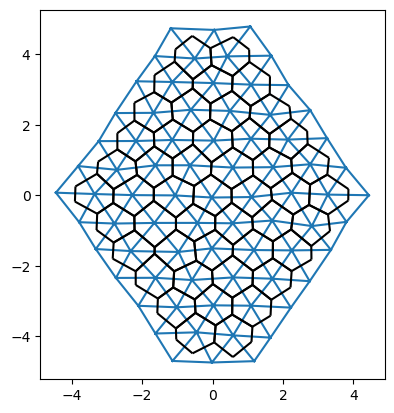

In [ ]:
mesh_initial = tns.TensionHalfEdgeMesh(get_tri_hemesh(nx=9, ny=13, noise=.05))
mesh_initial.transform_vertices(shear_mat(s=1.1))
mesh_initial.set_rest_lengths()
mesh_initial.set_voronoi()

mesh_initial.triplot()
mesh_initial.cellplot()
plt.gca().set_aspect('equal')

plt.show()

In [ ]:
## parameters

m = 2
k = .25
dt = .005

n_steps = 100

param_dict = {'m': m, 'k': k}

In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # keeps track of T1s. T1_count = np.cumsum([len(x) for x in last_flipped_edge])

save_dir = 'runs/delaunay_test'
try:
    os.mkdir(save_dir)
except FileExistsError:
    print('Warning: directory exists')

In [ ]:
mesh = deepcopy(meshes[-1])

for i in tqdm(range(n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs_tension=tns.excitable_dt_act_pass, params=param_dict)
    # flatten
    mesh.flatten_triangulation(reset_intrinsic=True)
    mesh.set_voronoi()
    # check for intercalation
    angles = mesh.get_double_angles()
    flip_edge = max(angles, key=angles.get)
    if angles[flip_edge] > np.pi:
        print("flip ", i)
        he = mesh.hes[flip_edge]
        try:
            mesh.flip_edge(flip_edge)
        except ValueError:
            break
        # resetting the active and passive tensions
        mesh.reset_rest_passive_flip(mesh.hes[flip_edge])
        last_flipped_edges.append([flip_edge])
    else:
        last_flipped_edges.append([])
    # rescale & reorient triangulation
    mesh.transform_vertices(get_conformal_transform(meshes[-1], mesh))
    # save
    mesh.save_mesh(f"{save_dir}/{str(i).zfill(4)}_mesh.txt")
    # log
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)    
    
last_flipped_edges.append([])
times = np.array(times)

  0%|          | 0/100 [00:00<?, ?it/s]

flip  13
flip  24
flip  25
flip  27
flip  28
flip  30
flip  31
flip  32
flip  33
flip  34
flip  35
flip  36
flip  37
flip  38
flip  39
flip  40
flip  41
flip  42
flip  43
flip  44
flip  45
flip  46
flip  47
flip  48
flip  49
flip  50
flip  51
flip  52
flip  53
flip  54
flip  55
flip  56
flip  57
flip  58
flip  59
flip  60
flip  61
flip  62
flip  63
flip  64
flip  65
flip  66
flip  67
flip  68
flip  70
flip  72
flip  73
flip  75
flip  77
flip  78
flip  79
flip  85
flip  91


[<matplotlib.lines.Line2D>]

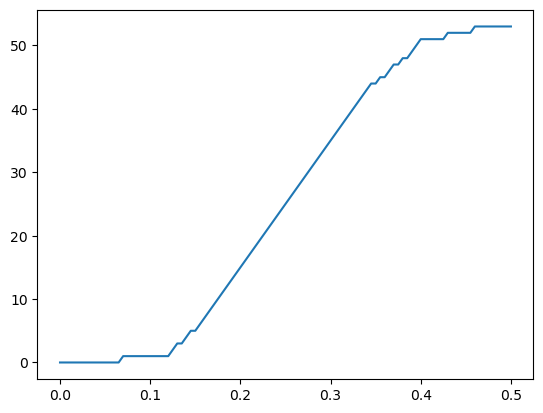

In [ ]:
T1_count = np.cumsum([len(x) for x in last_flipped_edges[:-1]])

plt.plot(times, T1_count)

In [ ]:
moments = np.stack([get_inertia(np.stack([v.coords for v in msh.vertices.values()])) for msh in meshes])

Text(0, 0.5, 'T1 count/Delaunay vertex')

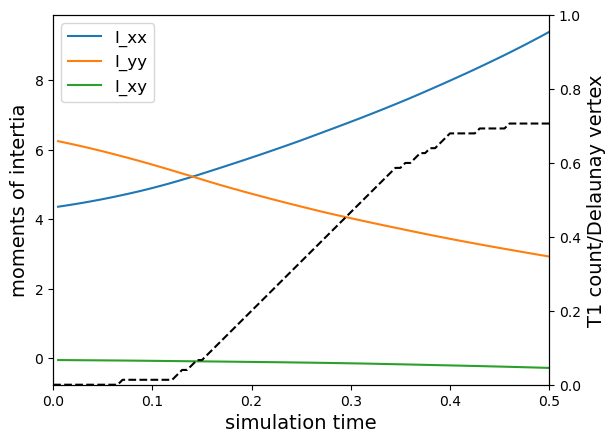

In [ ]:
#| notest

plt.plot(times[1:], moments[1:, 0,0], label="I_xx")
plt.plot(times[1:], moments[1:, 1,1], label="I_yy")
plt.plot(times[1:], moments[1:, 0,1], label="I_xy")
plt.xlim([0, times[-1]])

plt.xlabel("simulation time", fontsize=14)
plt.ylabel("moments of intertia", fontsize=14)
plt.legend(fontsize=12)

plt.gca().twinx().plot(times, np.array(T1_count)/len(mesh.vertices.values()), color="k", ls="dashed")
plt.ylim([0, 1])
plt.ylabel("T1 count/Delaunay vertex", fontsize=14)


## Creating slider plots and rendering a movie with ipywidgets

To do this, create a function to create plots of the mesh.

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
def plot_mesh(i):
    plt.cla()
    plt.xlim([-6, 6])
    plt.ylim([-6, 6])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot()
    meshes[i].triplot()
    for x in last_flipped_edges[i+1]:
        he = meshes[i].hes[x]
        line_primal = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        line_dual = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        plt.plot(*line_primal.T, c="r", lw=4)
        plt.plot(*line_dual.T, c="tab:purple", lw=4)

<IPython.core.display.Javascript object>


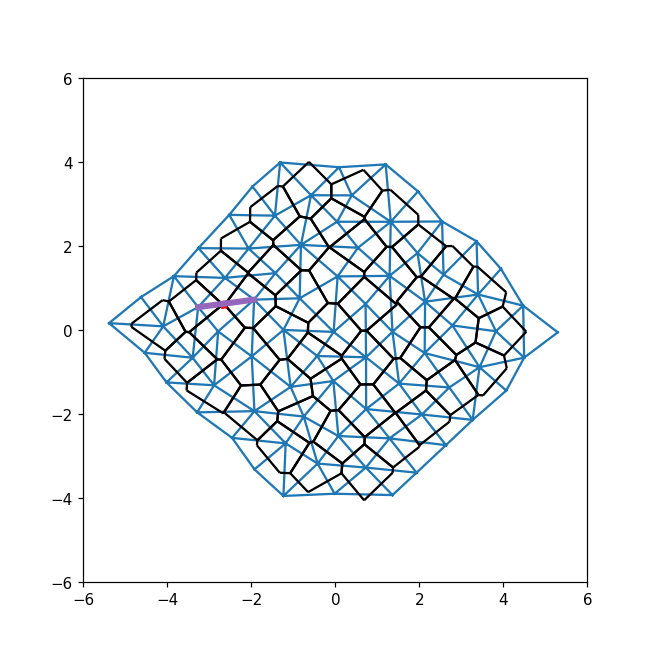

interactive(children=(IntSlider(value=50, description='i'), Output()), _dom_classes=('widget-interact',))

In [ ]:
#| notest

## slider plot

%matplotlib notebook

fig = plt.figure(figsize=(6, 6))
widgets.interact(plot_mesh, i=(0, len(meshes)-1, 1));

In [ ]:
#| notest
%matplotlib inline

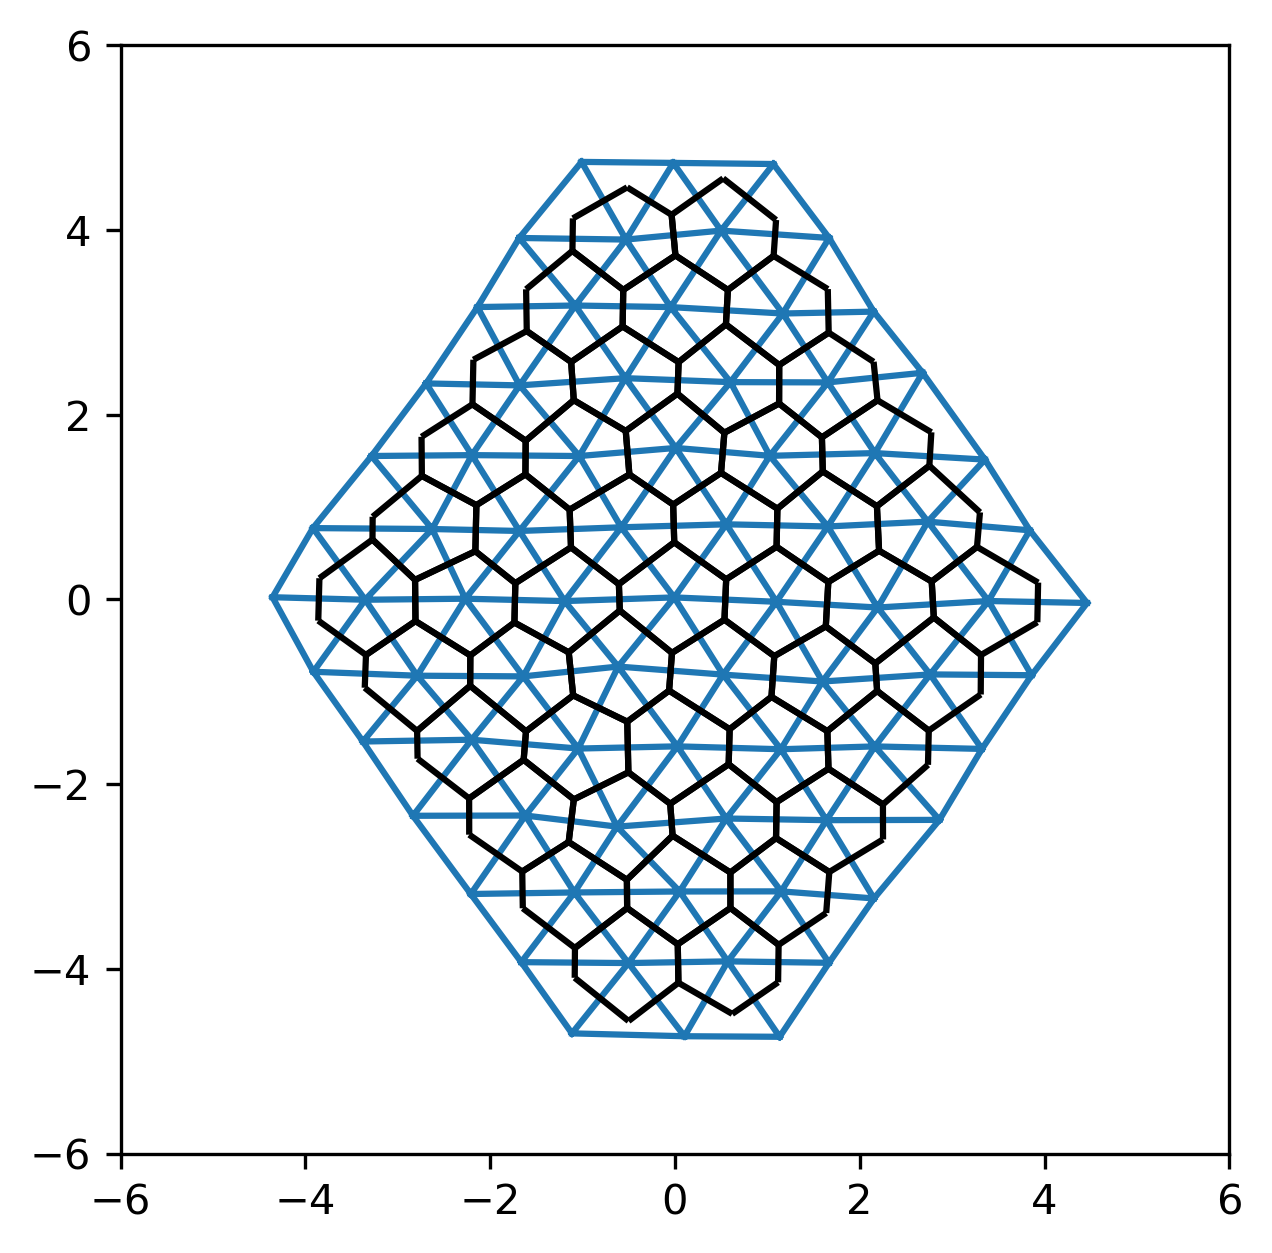

In [ ]:
#| notest
%matplotlib inline

## Save simulation as HTML5 animation

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300)
nframes, frame_dt = n_steps, 500  # Delay between frames in milliseconds

# run the animation
anim = animation.FuncAnimation(fig, plot_mesh, frames=nframes, interval=frame_dt, repeat=False)
anim.save('plots/delaunay_test.mp4', fps=4,)